# Data Loading and Preprocessing

In [ ]:
import pandas as pd
import os
import pickle
from google.colab import files
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import time
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
import lightgbm as ltb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import glob
from PIL import Image,ImageOps
from skimage.transform import resize
from skimage import color
from skimage.io import imread
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
train_path = '/content/drive/MyDrive/Train_Images/'

In [ ]:
train = files.upload()

Saving train.csv to train.csv


In [ ]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Image,Class
0,image7042.jpg,Food
1,image3327.jpg,misc
2,image10335.jpg,Attire
3,image8019.jpg,Food
4,image2128.jpg,Attire


In [ ]:
df_train['Class'].unique()

array(['Food', 'misc', 'Attire', 'Decorationandsignage'], dtype=object)

In [ ]:
img_label=[]
for img in glob.glob(train_path+"*.jpg"):
  label = img.title().lower().split('/')
  if label not in img_label:
      img_label.append(label[5])
  else:
      print(label[5])
print(len(img_label)) 

5983


In [ ]:
df = pd.DataFrame({'label':img_label})
df_new = pd.concat([df_train,df],axis=1)
df_sort=df_new.set_index('Image')

In [ ]:
label_class = []
for i in img_label:
  item = df_sort.loc[i,'Class']
  label_class.append(item)
print(len(label_class))

5983


In [ ]:
df = pd.DataFrame({'Class_label':label_class})
df_TrainSorted = pd.concat([df_new,df],axis=1)
df_TrainSorted.drop(['Image','Class'],axis=1,inplace=True)
df_TrainSorted['Class_label'] = df_TrainSorted['Class_label'].astype('category')
df_TrainSorted['Class_label_Cat'] = df_TrainSorted['Class_label'].cat.codes
df_TrainSorted.head()

,label,Class_label,Class_label_Cat
0,image471.jpg,misc,3
1,image8531.jpg,Attire,0
2,image7497.jpg,misc,3
3,image405.jpg,misc,3
4,image4427.jpg,misc,3


In [ ]:
coded_class = df_TrainSorted['Class_label_Cat'].tolist()

In [ ]:
def sort_images_drive():
  data=[]
  i=0
  count=[]
  for img in os.listdir( train_path ):
    imgpath = os.path.join(train_path,img)
    img_array=imread(imgpath)
    img_resized=resize(img_array,(50,50,3))
    image_flat=np.array(img_resized).flatten()
    image_flat = image_flat
    if (len(image_flat)) == 7500:
        data.append([image_flat,coded_class[i]])
    else:
        print(len(image_flat))
        count.append(i)
    i=i+1
  print(len(count))
  print(len(data))
  return data

In [ ]:
data=sort_images_drive()

0
5983


In [ ]:
pick_in = open('data.pickle','wb') 
pickle.dump(data,pick_in)
pick_in.close

<function BufferedWriter.close>

In [ ]:
pick_in = open('data.pickle','rb') 
data = pickle.load(pick_in)
pick_in.close

In [ ]:
features= []
labels = []
for feature,label in data:
  features.append(feature)
  labels.append(label)

In [ ]:
df=pd.DataFrame(features) #dataframe
df['Target']=labels

In [ ]:
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7461,7462,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472,7473,7474,7475,7476,7477,7478,7479,7480,7481,7482,7483,7484,7485,7486,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499,Target
0,0.427463,0.674522,0.882365,0.430984,0.678043,0.885886,0.433353,0.680412,0.888255,0.439608,0.686702,0.894510,0.443165,0.692941,0.898067,0.447059,0.695294,0.901961,0.450588,0.698039,0.905490,0.452941,0.700020,0.907843,0.455294,0.702388,0.910196,0.458824,0.705910,0.913753,0.454929,0.709816,0.918851,0.458431,0.713337,0.925098,0.460784,0.715686,0.927451,0.462745,...,0.467765,0.295196,0.228549,0.451137,0.270745,0.207604,0.435271,0.257596,0.188173,0.369706,0.243012,0.186961,0.422373,0.271784,0.205902,0.510765,0.328412,0.248039,0.555549,0.355941,0.273588,0.544153,0.350820,0.279447,0.463702,0.298604,0.242918,0.371871,0.236184,0.200498,0.318373,0.188961,0.153667,0.275235,0.148961,0.105431,0.370345,0.239757,0.184463,3
1,0.029882,0.023216,0.041020,0.023608,0.026745,0.044549,0.025176,0.034980,0.055647,0.026745,0.041647,0.052447,0.017725,0.020078,0.017969,0.009075,0.005153,0.001082,0.003733,0.003341,0.000361,0.000000,0.014471,0.038000,0.099678,0.162478,0.223655,0.588565,0.679153,0.769741,0.571765,0.711765,0.807059,0.603137,0.736863,0.834902,0.624706,0.740392,0.852157,0.633333,...,0.784157,0.797882,0.837098,0.784533,0.808847,0.856298,0.741875,0.778737,0.826973,0.760251,0.773498,0.808792,0.758847,0.770612,0.805906,0.753686,0.763490,0.795922,0.754643,0.758384,0.785443,0.759514,0.762894,0.783678,0.786204,0.790125,0.805812,0.775137,0.775529,0.786063,0.754000,0.754000,0.759882,0.736831,0.736831,0.736831,0.733020,0.733020,0.733020,0
2,0.363216,0.378471,0.363451,0.425882,0.434078,0.420824,0.442549,0.450784,0.430000,0.461216,0.465922,0.444314,0.620902,0.625333,0.599843,0.433725,0.464314,0.414510,0.506157,0.529333,0.483059,0.479412,0.496078,0.463725,0.442706,0.449765,0.432118,0.443373,0.444941,0.441765,0.426078,0.406196,0.402000,0.579020,0.581843,0.562824,0.553529,0.575294,0.554902,0.665412,...,0.511765,0.466667,0.388235,0.510588,0.488235,0.434510,0.516549,0.524000,0.493804,0.516431,0.520353,0.496824,0.532941,0.536863,0.513333,0.522745,0.526667,0.503137,0.534078,0.538000,0.514471,0.596314,0.600235,0.576706,0.581098,0.592863,0.565412,0.515922,0.527686,0.500235,0.589216,0.600980,0.573529,0.619020,0.630784,0.603333,0.544314,0.556078,0.528627,3
3,0.331412,0.343843,0.277569,0.351176,0.363255,0.296627,0.345294,0.357059,0.288235,0.335490,0.347294,0.272745,0.348980,0.360863,0.286235,0.325725,0.337490,0.260627,0.321922,0.333686,0.251333,0.334510,0.346275,0.263922,0.343176,0.354941,0.272588,0.358824,0.373333,0.287961,0.362745,0.374510,0.297098,0.335686,0.350980,0.261569,0.360784,0.374510,0.272549,0.359686,...,0.538824,0.527451,0.389020,0.554588,0.543216,0.404784,0.538196,0.526824,0.388392,0.538431,0.547451,0.390196,0.531529,0.540549,0.383294,0.495882,0.510196,0.351176,0.502863,0.523608,0.362471,0.498549,0.526275,0.361686,0.516000,0.546078,0.380196,0.483529,0.522706,0.354078,0.449804,0.492941,0.324314,0.426196,0.470824,0.301451,0.482824,0.533804,0.361255,3
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001565,0.000000,0.000000,0.000000,0.001518,0.001518,0.001518,0.008667,0.008667,0.006431,0.053200,0.053200,0.049224,0.013141,0.013141,0.011800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3


# PCA Decompose

In [ ]:
pca = PCA(0.95).fit(x)

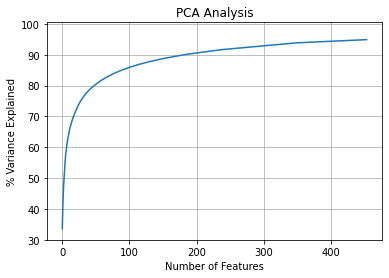

In [ ]:
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.grid()

In [ ]:
print('%d components explain 95%% of the variation in data' % pca.n_components_)

454 components explain 95% of the variation in data


In [ ]:
pca = PCA(n_components=454 , random_state = 42)
pca.fit(x)
x_pca = pca.transform(x)
print(x_pca.shape)

(5983, 454)


In [ ]:
X_train_pca,X_test_pca,y_train,y_test = train_test_split(x_pca,y,test_size=0.20,random_state=42,stratify=y)

# Classifier Models Compare

In [ ]:
# Initialize Regressors
nbc  = GaussianNB()
svc  = SVC()
dt   = DecisionTreeClassifier(random_state = 42)
rf   = RandomForestClassifier(random_state = 42)
knn  = KNeighborsClassifier()
sgd  = SGDClassifier(random_state=42)

In [ ]:
def model_train_list(model_list):
  # Create an empty list to append scores and Regressor name
  train_scores = []
  test_scores = []
  reg_names = []

  # Train Regressor over train data and append scores to empty list
  for reg in model_list:
    # Fit the train data over the Regressor object
    start = time.time()
    reg.fit(X_train_pca, y_train)
    y_predict = reg.predict(X_test_pca) 
    y_predict_tr = reg.predict(X_train_pca)  
    end = time.time()
    # Append train and test score to the empty list
    train_scores.append(accuracy_score(y_train,y_predict_tr))
    test_scores.append(accuracy_score(y_test,y_predict))
    #rmse_train.append(math.sqrt(mean_squared_error(y_train,y_predict_tr)))
    #rmse_test.append(math.sqrt(mean_squared_error(y_test,y_predict)))               
    reg_names.append(reg.__class__.__name__)
    print(reg.__class__.__name__,':',np.round(end-start,decimals=2),'secs \n')
  #Create an accuracy dataframe from scores and names list
  accuracy_frame = pd.DataFrame(data={'Train Accuracy': train_scores, 'Test Accuracy': test_scores}, index=reg_names)
  #View the accuracy of all the regressors
  return accuracy_frame.round(5)

In [ ]:
def model_fit_predict(model):
  model.fit(X_train_pca, y_train)
  y_predict = model.predict(X_test_pca) 
  y_predict_tr = model.predict(X_train_pca)  
  acc_tr = accuracy_score(y_train,y_predict_tr)
  acc_tst = accuracy_score(y_test,y_predict)
  # Append train and test score to the empty list
  accuracy_frame = pd.DataFrame(data={'Accuracy': [acc_tr,acc_tst]}, 
                                      index=['Train','Test'])

  print(accuracy_frame.round(5))

In [ ]:
# Intialize a list of Regressor objects
%%time
reg_list = [ nbc,sgd,svc, dt, rf, knn]
accuracy_frame = model_train_list(reg_list)

GaussianNB : 0.09 secs 

SGDClassifier : 2.59 secs 

SVC : 34.33 secs 

DecisionTreeClassifier : 2.47 secs 

RandomForestClassifier : 8.39 secs 

KNeighborsClassifier : 18.12 secs 

CPU times: user 1min 6s, sys: 199 ms, total: 1min 6s
Wall time: 1min 5s


In [ ]:
accuracy_frame.sort_values(by=['Test Accuracy'],ascending=False)  ##rgb2gray(80x60)

,Train Accuracy,Test Accuracy
SVC,0.61387,0.47285
RandomForestClassifier,0.99666,0.40434
GaussianNB,0.41099,0.39599
KNeighborsClassifier,0.53907,0.35088
DecisionTreeClassifier,0.99666,0.33751
SGDClassifier,0.41601,0.33166


In [ ]:
accuracy_frame.sort_values(by=['Test Accuracy'],ascending=False)  ##(80x60x3)

,Train Accuracy,Test Accuracy
SVC,0.70560,0.52715
GaussianNB,0.42541,0.42941
RandomForestClassifier,0.99666,0.42523
KNeighborsClassifier,0.57543,0.40267
SGDClassifier,0.46887,0.39265
DecisionTreeClassifier,0.99666,0.37928


In [ ]:
accuracy_frame.sort_values(by=['Test Accuracy'],ascending=False)  ##(50x50x3)

,Train Accuracy,Test Accuracy
SVC,0.70414,0.52297
SGDClassifier,0.52925,0.44528
RandomForestClassifier,0.99666,0.43275
GaussianNB,0.43042,0.42774
KNeighborsClassifier,0.57397,0.39683
DecisionTreeClassifier,0.99666,0.35673


# SVC Tune

In [ ]:
model = SVC()

In [ ]:
param_grid={'C':[0.01,0.1,0.5,1,2,5,10],'gamma':[0.0001,0.001,0.01,0.1,1]}
model_tuned=GridSearchCV(model,param_grid,n_jobs=-1,verbose=3,cv=3,scoring='accuracy')

In [ ]:
%%time
model_tuned.fit(X_train_pca,y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed: 11.5min finished


CPU times: user 20 s, sys: 466 ms, total: 20.4 s
Wall time: 11min 46s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=3)

In [ ]:
model_tuned.best_params_

{'C': 2, 'gamma': 0.001}

In [ ]:
svc_hyper = model_tuned.best_estimator_

In [ ]:
svc_hyper = SVC(C= 2, gamma= 0.001)

In [ ]:
%%time
model_fit_predict(svc_hyper)

       Accuracy
Train   0.69996
Test    0.52799
CPU times: user 43 s, sys: 60.2 ms, total: 43 s
Wall time: 42.9 s


# Tensorflow keras

In [ ]:
!nvidia-smi

Tue May 25 13:28:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import to_categorical
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [ ]:
Train_path = '/content/drive/MyDrive/Train_Images/'
valid_path = '/content/drive/MyDrive/Test_Images/'

In [ ]:
train_image = []
for i in tqdm(range(df_TrainSorted.shape[0])):
    img = image.load_img(Train_path+df_TrainSorted.loc[i,'label'],target_size=(224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 5983/5983 [00:10<00:00, 549.56it/s]


In [ ]:
X.shape

(5983, 224, 224, 3)

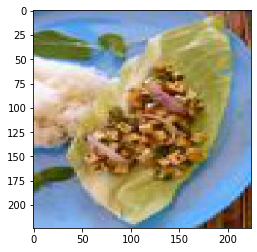

In [ ]:
plt.imshow(X[2001])

In [ ]:
df_TrainSorted.loc[2001,'Class_label']

'Food'

In [ ]:
df_TrainSorted['Class_label'] = df_TrainSorted['Class_label'].astype('category')
df_TrainSorted['Class_label_Cat'] = df_TrainSorted['Class_label'].cat.codes
df_TrainSorted.head()

,label,Class_label,Class_label_Cat
0,image471.jpg,misc,3
1,image8531.jpg,Attire,0
2,image7497.jpg,misc,3
3,image405.jpg,misc,3
4,image4427.jpg,misc,3


In [ ]:
df_TrainSorted['Class_label'] = df_TrainSorted['Class_label'].astype('category')
df_keras = pd.get_dummies(df_TrainSorted['Class_label'])
df_keras.head()

,Attire,Decorationandsignage,Food,misc
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [ ]:
y = np.array(df_keras)
y.shape

(5983, 4)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=62, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))


model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Conv2D(filters=256, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=256, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=512, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, activation="relu"))
model.add(Conv2D(filters=512, kernel_size=3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

#model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))

#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))
model.add(Dense(4,activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 109, 109, 62)      17918     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 62)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 52, 52, 128)       71552     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 50, 50, 128)       147584    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 25, 128)      

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))#, batch_size=32)

Epoch 1/10
 12/141 [=>............................] - ETA: 11:55 - loss: 1.4341 - accuracy: 0.2889

# Prediction

In [ ]:
test_path = '/content/drive/MyDrive/Test_Images/'

In [ ]:
test = files.upload()
df_test = pd.read_csv('test.csv')
df_test.head()

Saving test.csv to test.csv


,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg


In [ ]:
test_img_label=[]
for img in glob.glob(test_path+"*.jpg"):
  label = img.title().lower().split('/')
  if label not in test_img_label:
      test_img_label.append(label[5])
  else:
      print(label[5])
print(len(test_img_label)) 

3219


In [ ]:
df_test_sort = pd.DataFrame({'label':test_img_label})
df_new_test = pd.concat([df_test,df_test_sort],axis=1)
#df_sortTest=df_new_test.set_index('Image')

In [ ]:
df_new_test.head()

,Image,label
0,image6245.jpg,image8412.jpg
1,image10409.jpg,image3028.jpg
2,image8692.jpg,image7050.jpg
3,image10517.jpg,image9836.jpg
4,image2580.jpg,image8267.jpg


In [ ]:
data_test=[]
i=0
count=[]
for img in os.listdir(test_path):
  imgpath = os.path.join(test_path,img)
  img_array=imread(imgpath)
  img_resized=resize(img_array,(50,50,3))
  image_flat=np.array(img_resized).flatten()
  image_flat = image_flat
  if (len(image_flat)) == 7500:
    data_test.append(image_flat)
  else:
    print(len(image_flat))
    count.append(i)
  i=i+1
print(len(count))
print(len(data_test))

0
3219


In [ ]:
pick_in = open('data_test.pickle','wb') 
pickle.dump(data,pick_in)
pick_in.close

<function BufferedWriter.close>

In [ ]:
df_test_pca = pd.DataFrame(data_test)

In [ ]:
df_test_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7460,7461,7462,7463,7464,7465,7466,7467,7468,7469,7470,7471,7472,7473,7474,7475,7476,7477,7478,7479,7480,7481,7482,7483,7484,7485,7486,7487,7488,7489,7490,7491,7492,7493,7494,7495,7496,7497,7498,7499
0,0.699490,0.633059,0.604549,0.284549,0.228549,0.180275,0.191765,0.155490,0.113137,0.588745,0.565176,0.461725,0.613647,0.598196,0.473647,0.636471,0.617529,0.484980,0.275765,0.240824,0.126392,0.369804,0.308824,0.219216,0.875843,0.793451,0.728706,0.876235,0.783961,0.734941,0.836471,0.806275,0.737137,0.840000,0.812549,0.745882,0.840392,0.816863,0.758039,0.844353,...,0.472392,0.633333,0.491961,0.456078,0.618078,0.476000,0.419529,0.623412,0.476745,0.407725,0.613451,0.438078,0.432941,0.544471,0.494824,0.432000,0.535882,0.457059,0.393137,0.580118,0.430392,0.387686,0.503569,0.398588,0.347490,0.500392,0.405608,0.358039,0.503765,0.381216,0.335333,0.451765,0.370980,0.271176,0.421529,0.322039,0.181529,0.524588,0.264980,0.144980
1,0.931000,0.802263,0.645439,0.924024,0.823392,0.643890,0.925314,0.853627,0.650725,0.930310,0.846137,0.655224,0.952588,0.856251,0.682204,0.948663,0.860000,0.678431,0.949020,0.866275,0.681961,0.952941,0.874255,0.690196,0.952941,0.882745,0.698039,0.955329,0.891408,0.700784,0.949980,0.891906,0.733188,0.981427,0.906784,0.724039,0.836863,0.738059,0.528510,0.650063,...,0.532482,0.986961,0.814157,0.516804,0.947569,0.746678,0.451031,0.983718,0.770416,0.474769,0.980216,0.779729,0.480322,0.990780,0.768325,0.468235,0.965216,0.721392,0.419510,0.959412,0.715686,0.407698,0.956310,0.727522,0.411863,0.954984,0.730945,0.417071,0.948937,0.718757,0.410443,0.908529,0.669569,0.363608,0.880376,0.633318,0.329486,0.859655,0.612596,0.305694
2,0.341165,0.151247,0.002663,0.341729,0.145455,0.000212,0.348059,0.139686,0.002490,0.363235,0.141992,0.012855,0.384647,0.147514,0.024569,0.381369,0.141918,0.027839,0.387937,0.148486,0.034302,0.368922,0.141294,0.026980,0.356945,0.133976,0.019400,0.359373,0.143486,0.025486,0.349290,0.137020,0.003922,0.349373,0.137020,0.003922,0.347529,0.131373,0.000176,0.346706,...,0.006282,0.054176,0.006412,0.003765,0.043494,0.003729,0.001400,0.037765,0.001529,0.000071,0.035224,0.020161,0.001141,0.038482,0.026247,0.007227,0.050569,0.034294,0.017118,0.045251,0.025055,0.010376,0.025176,0.002318,0.000000,0.025812,0.000635,0.000518,0.045298,0.010529,0.000247,0.052588,0.017176,0.000118,0.059278,0.019671,0.000388,0.069541,0.023659,0.001035
3,0.127569,0.122706,0.176863,0.734431,0.676275,0.795569,0.980588,0.973333,0.980980,0.933137,0.968902,0.926902,0.959725,0.963412,0.979137,0.960078,0.956235,0.944039,0.740471,0.775020,0.975333,0.655490,0.689216,0.829412,0.974196,0.987804,0.935725,0.975255,0.972588,0.976941,0.686902,0.598980,0.625843,0.323255,0.102941,0.080941,0.265490,0.126471,0.073333,0.407020,...,0.003922,0.001961,0.009804,0.005882,0.003176,0.010980,0.007059,0.000000,0.004980,0.001059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002745,0.000118,0.000000,0.006000,0.004275,0.003882,0.012902,0.031176,0.027255,0.047059,0.050275,0.046353,0.065961,0.008941,0.007765,0.027098
4,0.622706,0.330157,0.316392,0.622118,0.326824,0.317412,0.610196,0.309804,0.309216,0.579176,0.280471,0.287804,0.544471,0.256118,0.271098,0.531059,0.253451,0.273804,0.492392,0.226510,0.251216,0.459804,0.212353,0.240000,0.438980,0.204745,0.233765,0.416392,0.195255,0.228118,0.285176,0.199176,0.241176,0.332902,0.189922,0.247451,0.428431,0.217255,0.276667,0.500235,...,0.722627,0.822353,0.767451,0.715882,0.807843,0.757255,0.706157,0.799961,0.750157,0.696078,0.802000,0.742000,0.683176,0.806392,0.743647,0.684824,0.807451,0.743333,0.685882,0.802196,0.739451,0.680627,0.798078,0.735333,0.673765,0.824549,0.760980,0.699059,0.788902,0.726157,0.663412,0.866471,0.805686,0.733137,0.894157,0.835333,0.760824,0.874353,0.815529,0.741020


In [ ]:
x_test_pca = pca.transform(df_test_pca)
print(x_test_pca.shape)

(3219, 454)


In [ ]:
predictions = svc_hyper.predict(x_test_pca)
df_new_test['predictions'] = predictions
df_new_test.head()

,Image,label,predictions
0,image6245.jpg,image8412.jpg,2
1,image10409.jpg,image3028.jpg,2
2,image8692.jpg,image7050.jpg,2
3,image10517.jpg,image9836.jpg,3
4,image2580.jpg,image8267.jpg,2


In [ ]:
final_list = []
for i in range(0,3219):
  df_new_test.loc[i,'Class']= df_new_test.loc[df_new_test['label']==df_new_test.loc[i,'Image'],'predictions'].iloc[0]
df_new_test.head()

,Image,label,predictions,Class,Class_code
0,image6245.jpg,image8412.jpg,2,2.0,2.0
1,image10409.jpg,image3028.jpg,2,2.0,2.0
2,image8692.jpg,image7050.jpg,2,2.0,2.0
3,image10517.jpg,image9836.jpg,3,2.0,2.0
4,image2580.jpg,image8267.jpg,2,1.0,1.0


In [ ]:
predicted_labels = []
for i in df_new_test['Class_code'].tolist():
  if i == 0.0:
    predicted_labels.append('Attire')
  elif i == 1.0:
    predicted_labels.append('Decorationandsignage')
  elif i == 2.0:
    predicted_labels.append('Food')
  elif i == 3.0:
    predicted_labels.append('misc')
print(len(predicted_labels))

3219


In [ ]:
df_new_test['Class'] = predicted_labels
df_new_test.head()

,Image,label,predictions,Class,Class_code
0,image6245.jpg,image8412.jpg,2,Food,2.0
1,image10409.jpg,image3028.jpg,2,Food,2.0
2,image8692.jpg,image7050.jpg,2,Food,2.0
3,image10517.jpg,image9836.jpg,3,Food,2.0
4,image2580.jpg,image8267.jpg,2,Decorationandsignage,1.0


In [ ]:
predicted_df = df_new_test[['Image','Class']]
predicted_df = predicted_df.set_index('Image')
predicted_df.to_csv('Image Submission.csv')
files.download('Image Submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>